In [1]:
# FINAL COMPARISON: Tuning Impact Across Horizons
import sys
from pathlib import Path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor

from ml_logic.data_preprocessing import clean_data, resample_pings, vessel_train_test_split
from ml_logic.feature_engineering import create_time_series_features
from ml_logic.metric import haversine_mae, position_extrapolation

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
# get initial data frame
df = pd.read_parquet("../data/raw/AIS_merged_lon-95.0to-77.2_lat22.5to29.5_20241101to20241130.parquet")

df = clean_data(df) #remove missing values and clean
df = resample_pings(df, interval='10min') #uniformize pings

/Users/pablorougerie/code/Projets/shanty_project/ml_logic/data_preprocessing.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[dimension_cols] = df[dimension_cols].replace(0, np.nan)


In [3]:
# Split by vessel before creating features (consistent with DL workflow)
df_train, df_val, df_test, groups_train, groups_val, groups_test = vessel_train_test_split(
    df, test_size=0.2, val_size=0.15, random_state=273
)


In [4]:

# Features to remove (from feature selection)
features_to_remove = ["COG_lag_480min", "SOG_lag_240min", "COG_lag_240min",
                      "Heading", "COG_lag_80min"]

# Sampling parameters
n_debug = 100000
n_eval = 30000
np.random.seed(273)

In [5]:
# Define models
models = {
    "LightGBM (not tuned)": LGBMRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=273,
        n_jobs=-1,
        verbose=-1
    ),
    "LightGBM (tuned)": LGBMRegressor(
        n_estimators=400,  # Updated from grid search
        max_depth=8,  # Updated from grid search
        learning_rate=0.1,  # Updated from grid search
        min_child_samples=40,  # Updated from grid search
        reg_lambda=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=273,
        n_jobs=-1,
        verbose=-1
    ),
    "Ridge (scaled)": Pipeline([
        ('scaler', RobustScaler()),
        ('model', Ridge(alpha=1.0))
    ])
}


In [6]:

# Test horizons: 1h, 3h, 6h, 12h, 24h + additional granular points
horizons = [60, 120, 180, 300, 360, 420, 540, 660, 720, 840, 900, 960, 1020, 1140, 1260, 1380, 1440, 1500, 1620, 1740, 1860, 1980, 2160]

# Storage
results = []

print("Starting horizon comparison...")
print(f"Testing {len(horizons)} horizons with {len(models)} models + baseline")
print(f"Sampling: {n_debug} train, {n_eval} val samples per horizon\n")

for horizon in horizons:
    print(f"=== Horizon: {horizon}min ({horizon/60:.1f}h) ===")

    # 1. Create features for each horizon on the already-split datasets
    df_train_horizon = create_time_series_features(df_train, target_horizon=horizon, time_step=10,
                                                    rolling=False, advanced_features=False)
    df_val_horizon = create_time_series_features(df_val, target_horizon=horizon, time_step=10,
                                                  rolling=False, advanced_features=False)
    df_test_horizon = create_time_series_features(df_test, target_horizon=horizon, time_step=10,
                                                   rolling=False, advanced_features=False)

    # 2. Separate X, y for each set
    X_train_h = df_train_horizon.drop(columns=["MMSI", "BaseDateTime", "target_LAT", "target_LON"])
    y_train_h = df_train_horizon[["target_LAT", "target_LON"]]

    X_val_h = df_val_horizon.drop(columns=["MMSI", "BaseDateTime", "target_LAT", "target_LON"])
    y_val_h = df_val_horizon[["target_LAT", "target_LON"]]

    X_test_h = df_test_horizon.drop(columns=["MMSI", "BaseDateTime", "target_LAT", "target_LON"])
    y_test_h = df_test_horizon[["target_LAT", "target_LON"]]

    # 3. Remove features selected for deletion (if they exist for this horizon)
    # Note: feature names depend on horizon, so we filter dynamically
    horizon_features_to_remove = [f for f in features_to_remove if f in X_train_h.columns]
    if horizon_features_to_remove:
        X_train_h = X_train_h.drop(columns=horizon_features_to_remove)
        X_val_h = X_val_h.drop(columns=horizon_features_to_remove)
        X_test_h = X_test_h.drop(columns=horizon_features_to_remove)

    # 4. Sample random rows from train/val for this horizon
    # Random sampling is safe since vessel_train_test_split already ensures no vessel overlap
    n_train_sample = min(n_debug, len(X_train_h))
    n_val_sample = min(n_eval, len(X_val_h))

    train_indices_h = np.random.choice(len(X_train_h), n_train_sample, replace=False)
    val_indices_h = np.random.choice(len(X_val_h), n_val_sample, replace=False)

    X_train_sampled = X_train_h.iloc[train_indices_h]
    y_train_sampled = y_train_h.iloc[train_indices_h]

    X_val_sampled = X_val_h.iloc[val_indices_h]
    y_val_sampled = y_val_h.iloc[val_indices_h]

    # 5. Baseline: linear extrapolation using current position, SOG, and COG
    LAT_pred_baseline, LON_pred_baseline = position_extrapolation(X_test_h, time_horizon=horizon)
    y_pred_baseline = np.column_stack([LAT_pred_baseline, LON_pred_baseline])
    mae_baseline = haversine_mae(y_test_h.values, y_pred_baseline)

    print(f"  Baseline: {mae_baseline:.3f} km")

    row = {
        'horizon_min': horizon,
        'Baseline': mae_baseline
    }

    # 6. Models - train on sampled train set, evaluate on test set
    for name, model in models.items():
        multi_model = MultiOutputRegressor(model)
        multi_model.fit(X_train_sampled, y_train_sampled)
        y_pred = multi_model.predict(X_test_h)
        mae = haversine_mae(y_test_h.values, y_pred)

        print(f"  {name}: {mae:.3f} km")
        row[name] = mae

    results.append(row)
    print()

# Create DataFrame
results_df = pd.DataFrame(results)


Starting horizon comparison...
Testing 23 horizons with 3 models + baseline
Sampling: 100000 train, 30000 val samples per horizon

=== Horizon: 60min (1.0h) ===
Target prediction horizon: 60 min. Number of steps: 6
Defining lag windows of 10min, 30min, 60min
Target prediction horizon: 60 min. Number of steps: 6
Defining lag windows of 10min, 30min, 60min
Target prediction horizon: 60 min. Number of steps: 6
Defining lag windows of 10min, 30min, 60min
  Baseline: 1.548 km
  LightGBM (not tuned): 5.035 km
  LightGBM (tuned): 4.800 km
  Ridge (scaled): 3.974 km

=== Horizon: 120min (2.0h) ===
Target prediction horizon: 120 min. Number of steps: 12
Defining lag windows of 20min, 60min, 120min
Target prediction horizon: 120 min. Number of steps: 12
Defining lag windows of 20min, 60min, 120min
Target prediction horizon: 120 min. Number of steps: 12
Defining lag windows of 20min, 60min, 120min
  Baseline: 3.876 km
  LightGBM (not tuned): 7.685 km
  LightGBM (tuned): 7.225 km
  Ridge (scaled):

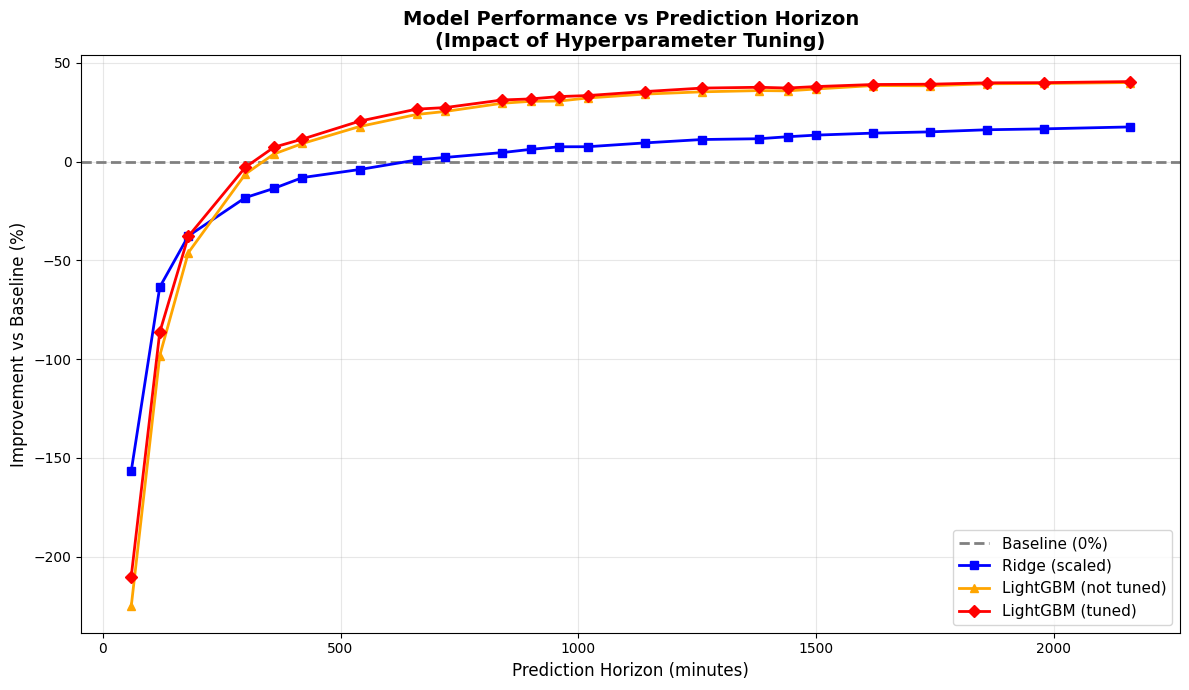


=== KEY IMPROVEMENTS: ML vs Baseline ===
Horizons selected to show transition from baseline dominance to ML superiority

Horizon: 60min (1.0h) | Baseline: 1.55 km
  LightGBM (tuned): 4.80 km (-210.1% - baseline better)

Horizon: 180min (3.0h) | Baseline: 6.86 km
  LightGBM (tuned): 9.45 km (-37.9% - baseline better)

Horizon: 360min (6.0h) | Baseline: 18.41 km
  LightGBM (tuned): 17.07 km (+7.3% improvement)

Horizon: 720min (12.0h) | Baseline: 48.23 km
  LightGBM (tuned): 35.04 km (+27.4% improvement)

Horizon: 1440min (24.0h) | Baseline: 113.77 km
  LightGBM (tuned): 71.37 km (+37.3% improvement)

Horizon: 2160min (36.0h) | Baseline: 175.76 km
  LightGBM (tuned): 104.52 km (+40.5% improvement)



In [9]:
# Calculate % improvement vs baseline for each model
# Positive % means model is better than baseline (lower MAE = better)
for model_name in ['Ridge (scaled)', 'LightGBM (not tuned)', 'LightGBM (tuned)']:
    results_df[f'{model_name} (% vs baseline)'] = ((results_df['Baseline'] - results_df[model_name]) / results_df['Baseline']) * 100

# Visualization: plot % improvement vs baseline across all horizons
plt.figure(figsize=(12, 7))

# Baseline is 0% by definition (no improvement over itself)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=2, label='Baseline (0%)')

plt.plot(results_df['horizon_min'], results_df['Ridge (scaled) (% vs baseline)'],
         marker='s', linewidth=2, label='Ridge (scaled)', color='blue')
plt.plot(results_df['horizon_min'], results_df['LightGBM (not tuned) (% vs baseline)'],
         marker='^', linewidth=2, label='LightGBM (not tuned)', color='orange')
plt.plot(results_df['horizon_min'], results_df['LightGBM (tuned) (% vs baseline)'],
         marker='D', linewidth=2, label='LightGBM (tuned)', color='red')

plt.xlabel('Prediction Horizon (minutes)', fontsize=12)
plt.ylabel('Improvement vs Baseline (%)', fontsize=12)
plt.title('Model Performance vs Prediction Horizon\n(Impact of Hyperparameter Tuning)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../visualizations/model_performance_vs_horizon.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate improvement percentages at key horizons for ML vs Baseline comparison
# Selected horizons: 1h, 3h, 6h, 12h, 24h, 36h
# These show the transition from baseline dominance (short-term) to ML superiority (long-term)
key_horizons = [60, 180, 360, 720, 1440, 2160]  # 1h, 3h, 6h, 12h, 24h, 36h

print("\n=== KEY IMPROVEMENTS: ML vs Baseline ===")
print("Horizons selected to show transition from baseline dominance to ML superiority\n")

for h in key_horizons:
    if h not in results_df['horizon_min'].values:
        continue  # Skip if horizon not in results

    row = results_df[results_df['horizon_min'] == h].iloc[0]
    baseline = row['Baseline']

    print(f"Horizon: {h}min ({h/60:.1f}h) | Baseline: {baseline:.2f} km")

    # Show only the best ML model (LightGBM tuned) for clarity
    mae_tuned = row['LightGBM (tuned)']
    improvement_tuned = ((baseline - mae_tuned) / baseline * 100)

    if improvement_tuned > 0:
        print(f"  LightGBM (tuned): {mae_tuned:.2f} km ({improvement_tuned:+.1f}% improvement)")
    else:
        print(f"  LightGBM (tuned): {mae_tuned:.2f} km ({improvement_tuned:.1f}% - baseline better)")
    print()

## Conclusion: Model Performance and Real-World Impact

### Performance Summary

**Short-term (1-3h)**: Baseline outperforms ML models. At 1h, baseline error is 1.55 km vs 4.80 km for LightGBM (tuned).

**Long-term (6h+)**: LightGBM (tuned) consistently outperforms baseline:
- **6h**: 17.07 km vs 18.41 km baseline → **7.3% improvement** (1.3 km reduction)
- **12h**: 35.04 km vs 48.23 km baseline → **27.4% improvement** (13.2 km reduction)
- **24h**: 71.37 km vs 113.77 km baseline → **37.3% improvement** (42.4 km reduction)
- **36h**: 104.52 km vs 175.76 km baseline → **40.5% improvement** (71.2 km reduction)

### Search and Rescue Impact

For maritime search operations, error reduction translates directly to search area reduction (assuming circular search zones):

**24-hour prediction:**
- Baseline: 113.77 km radius → **40,600 km²** search area
- LightGBM (tuned): 71.37 km radius → **16,000 km²** search area
- **Reduction: 24,600 km² (60% smaller search zone)**

**36-hour prediction:**
- Baseline: 175.76 km radius → **97,000 km²** search area
- LightGBM (tuned): 104.52 km radius → **34,300 km²** search area
- **Reduction: 62,700 km² (65% smaller search zone)**

### Model Comparison

- **LightGBM (tuned)**: Best performance on long horizons (6h+), with 27-41% improvement over baseline
- **Ridge (scaled)**: Competitive alternative, simpler and faster
- **LightGBM (not tuned)**: Already robust; tuning adds 2-5% additional improvement

### Conclusion

LightGBM (tuned) provides **substantial operational value** for horizons beyond 6 hours, reducing prediction error by 13-71 km (27-41% improvement) and search areas by 25,000-63,000 km² (60-65% reduction). This translates to significantly more efficient search and rescue operations and improved maritime safety.

### Next Steps: Deep Learning Approach

While tree-based and linear models show strong performance, we will now explore **deep learning time series models** (LSTM/RNN) in the next notebook. These architectures can capture complex temporal dependencies and sequential patterns that may further improve prediction accuracy, especially for longer horizons where trajectory complexity increases.
